In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import opendatasets as od
mpl.style.use('fivethirtyeight')

%matplotlib inline

In [15]:
od.download('https://www.kaggle.com/competitions/titanic/data',
            'datasets', force=True)

100%|██████████| 34.1k/34.1k [00:00<00:00, 95.2kB/s]


Extracting archive datasets/titanic/titanic.zip to datasets/titanic


In [16]:
train = pd.read_csv('datasets/titanic/train.csv')
test = pd.read_csv('datasets/titanic/test.csv')
gen_sub = pd.read_csv('datasets/titanic/gender_submission.csv')

**Check sample submission**

In [17]:
gen_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


**Review Train Data**

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Dataset Features**

- survival - Label for the dataset. 0 = No, 1 = Yes
- pclass - Ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd
- sex - Sex
- age - Age  in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp - Number of siblings / spouses aboard the Titanic
- parch - Number of parents / children aboard the Titanic. Some children travelled only with a nanny, therefore parch=0 for them.
- ticket - Ticket number
- fare - Passenger fare
- cabin - Cabin number
- embard - Port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton

**Frame the Problem**

We're using passenger data from the Titanic dataset to predict passenger survival. This is a classification problem requiring a supervised learning algorithm, since we have our labels (the Survived column). We'll be using batch learning since all our information exists offline and on our local device.

**Select a Performance Measure**

We'll be using accuracy, confusion matrix, ROC curve and precision/recall metrics as our performance measures.

**Check Assumptions**

We assume ...

**Preview Data Structure**

There are 891 records. Age, cabin and embarked features have null values. All feature values are in the right datatype. Most of the data values are categorical, with only one numerical value type.

In [19]:
df = train.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
df.duplicated().sum()

0

In [21]:
for i in df.columns:
    print(df[i].value_counts())

PassengerId
1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: count, Length: 891, dtype: int64
Survived
0    549
1    342
Name: count, dtype: int64
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00

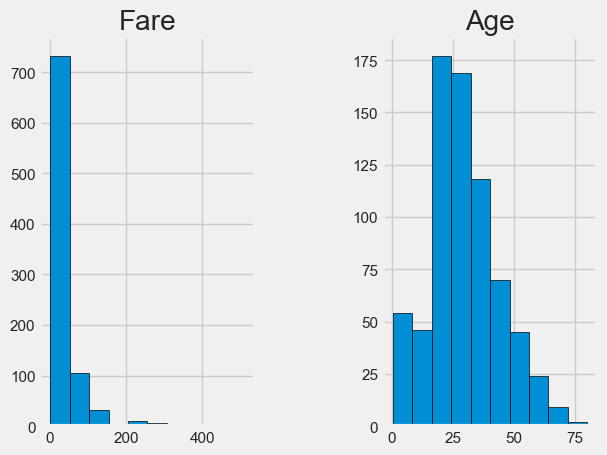

In [22]:
num_cols = ['Fare', 'Age']

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=0.6, wspace=0.6)

#create histograms
axs[0].hist(df[num_cols[0]], edgecolor='black')
axs[0].set_title(num_cols[0])
axs[1].hist(df[num_cols[1]], edgecolor='black')
axs[1].set_title(num_cols[1])

plt.show()

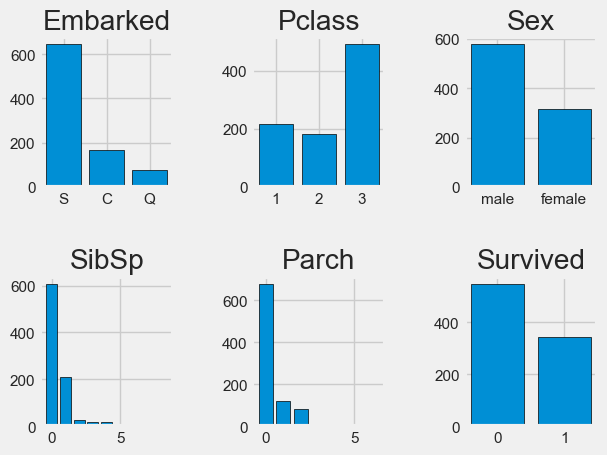

In [23]:
cat_cols = ['Embarked', 'Pclass', 'Sex', 'SibSp',
            'Parch', 'Survived']

fig, axs = plt.subplots(nrows=2, ncols=3)
fig.subplots_adjust(hspace=0.6, wspace=0.6)

#create barplots
for ax, col in zip(axs.ravel(), cat_cols):
    ax.bar(df[col].value_counts().index,
           df[col].value_counts(), ec='black')
    ax.set_title(col)

plt.show()

**Visualizing the Data / Exploratory Analysis**

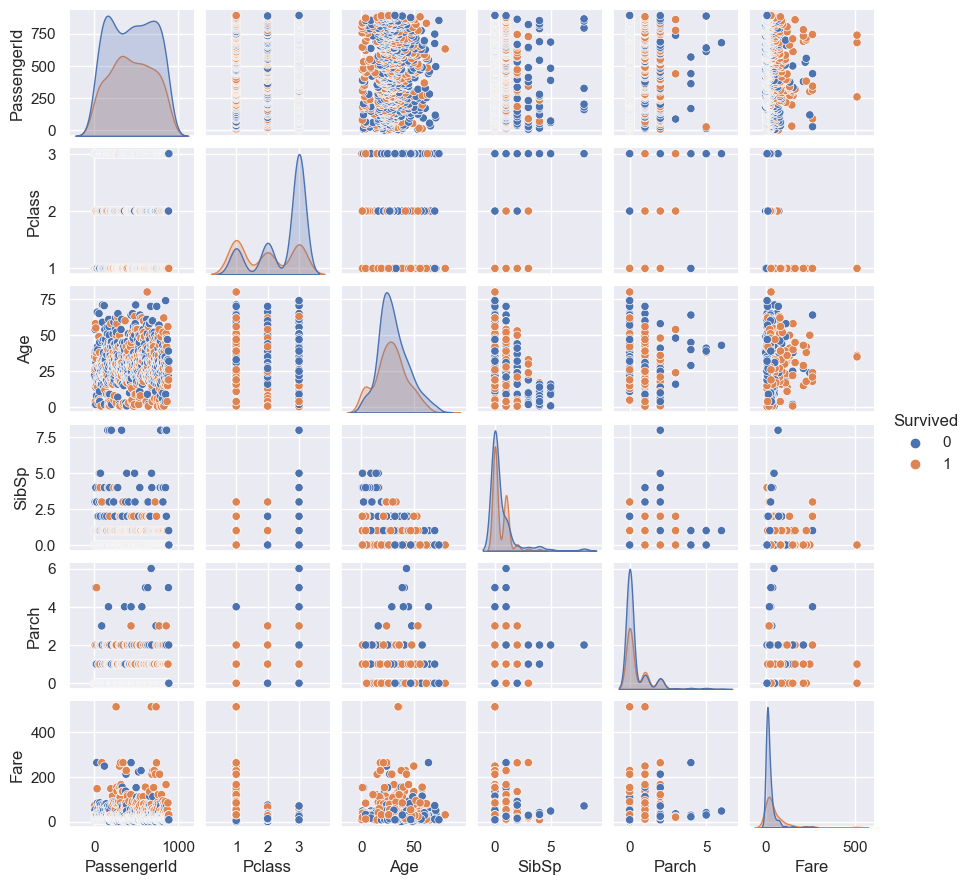

In [24]:
sns.set()
sns.pairplot(df, hue='Survived', height=1.5);

**Looking for Correlations**

There are linear correlations between different features (covariance) as well as between certain features and the label.

In [25]:
corr_cols = ['Pclass', 'Age', 'SibSp',
             'Parch', 'Fare', 'Survived']
df[corr_cols].corr()

,Pclass,Age,SibSp,Parch,Fare,Survived
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.338481
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.077221
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.035322
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225,0.081629
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000,0.257307
Survived,-0.338481,-0.077221,-0.035322,0.081629,0.257307,1.000000


Correlations exist between class, fare and survived. Class and number of siblings/ spouse is correlated with age. Fare is correlated with class and survived. We'll use attribute combinations to boost correlations if possible.

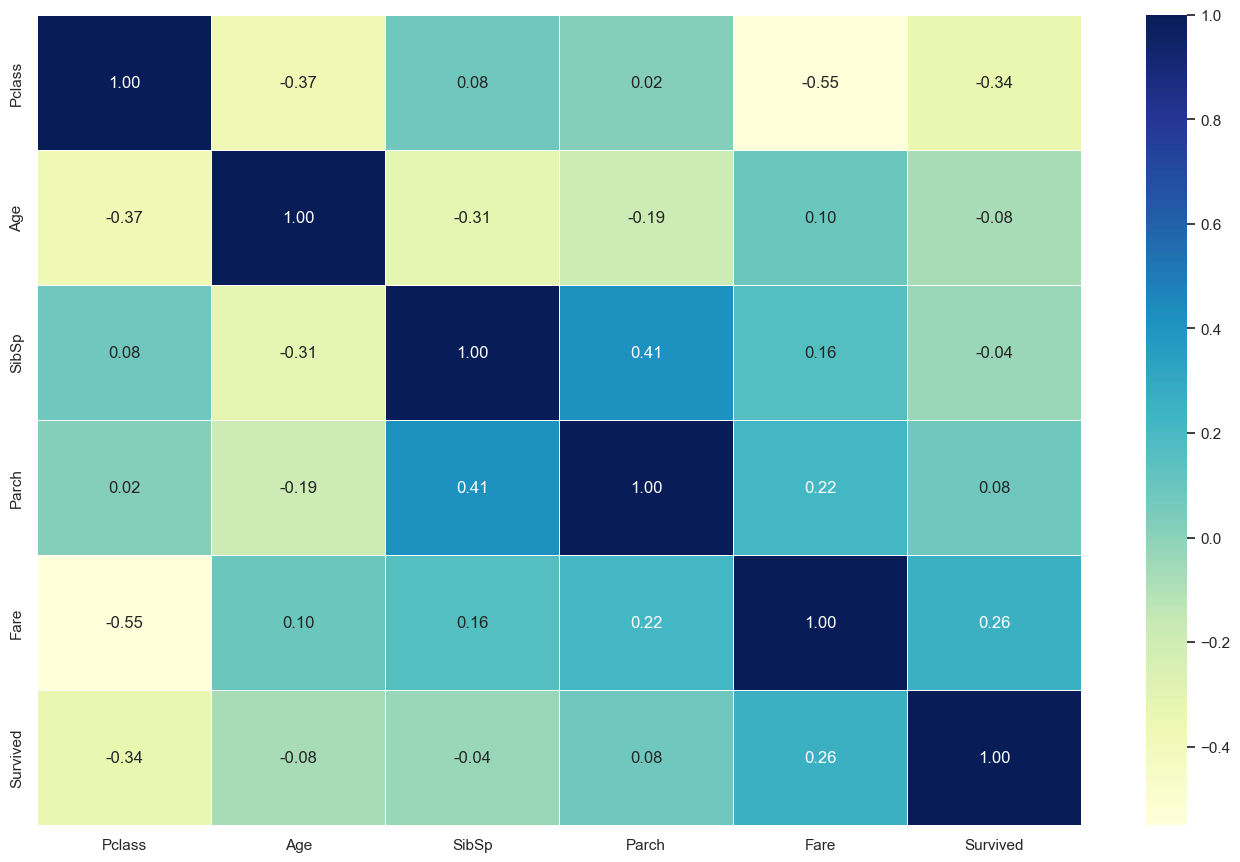

In [26]:
pear_corr = df[corr_cols].corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(pear_corr,
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu");

**Experimenting with Attribute Combinations**

We can try the following attribute combinations:
- Fare per Age
- Fare per Pclass
- SibSp per Pclass
- SibSp per Fare
- Parch per Fare

Fare per class and fare per sibling/spouse are correlated with survival.

In [27]:
df['Fare_per_age'] = df.Fare/df.Age
df['Fare_per_pclass'] = df.Fare/df.Pclass
df['Sibsp_per_pclass'] = df.SibSp/df.Pclass
df['Fare_per_Sibsp'] = df.Fare/df.SibSp
df['Fare_per_Parch'] = df.Fare/df.Parch

df[['Fare_per_age', 'Fare_per_pclass', 'Survived',
    'Sibsp_per_pclass', 'Fare_per_Sibsp',
    'Fare_per_Parch']].corr()['Survived']

Fare_per_age        0.138080
Fare_per_pclass     0.267627
Survived            1.000000
Sibsp_per_pclass    0.088239
Fare_per_Sibsp      0.312984
Fare_per_Parch      0.145439
Name: Survived, dtype: float64

In [28]:
attributes = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
              'Survived', 'Fare_per_age', 'Fare_per_pclass',
              'Sibsp_per_pclass', 'Fare_per_Sibsp',
              'Fare_per_Parch']


**Prepare Data for ML Algorithm**

We'll prepare our train, label sets.
We'll also handle missing data and log transform the Fare column.

In [29]:
df1 = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
        'Fare', 'Embarked', 'Fare_per_age',
        'Fare_per_pclass', 'Sibsp_per_pclass',
        'Fare_per_Sibsp', 'Fare_per_Parch']].copy()
labels = df['Survived'].copy()

<Axes: >

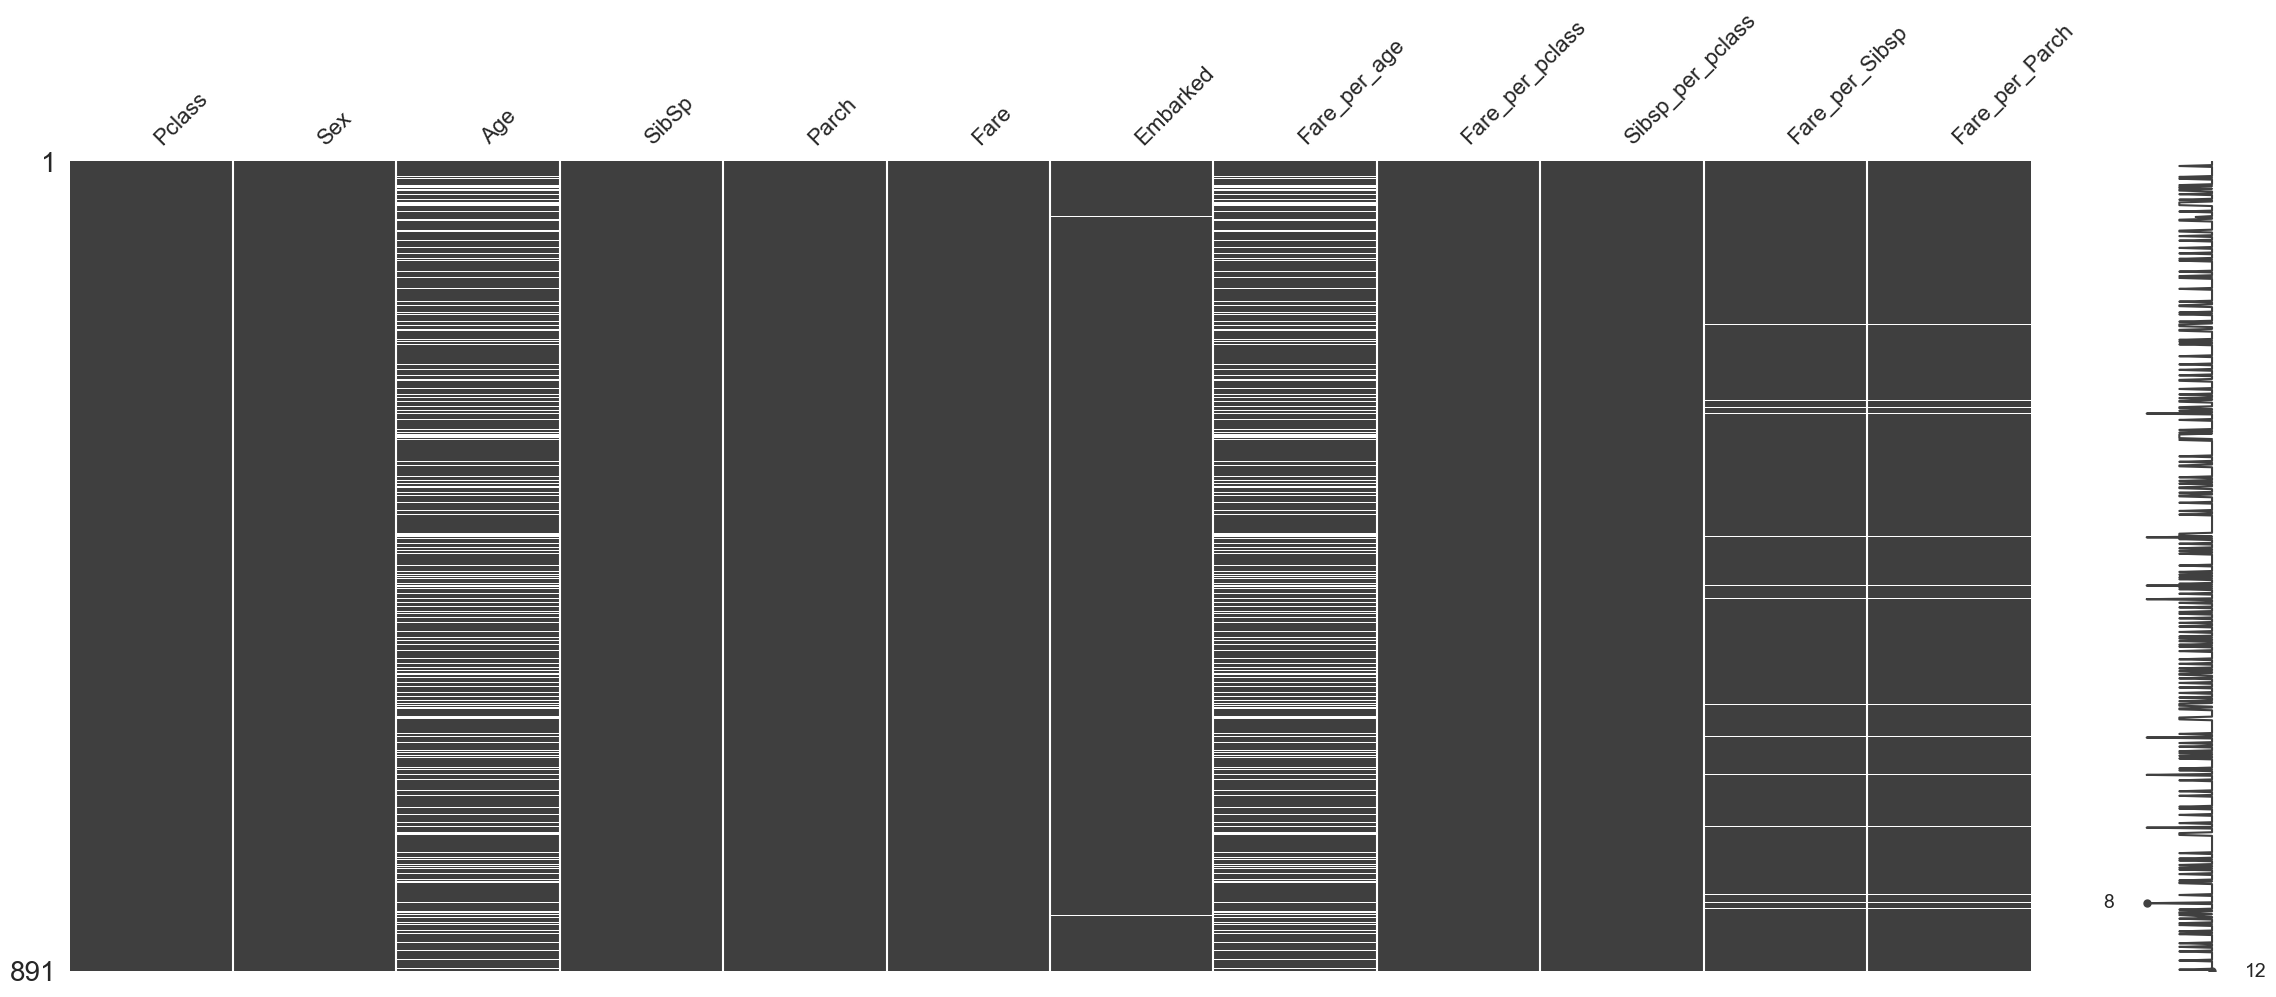

In [30]:
import missingno as msno
msno.matrix(df1)

Most of the null values are in Age and its derivative columns. The combined fare columns have missing data which is most likely attributable to zero division errors.

In [31]:
df1[['Age', 'Embarked', 'Fare_per_age',
    'Fare_per_Sibsp', 'Fare_per_Parch']].isnull().sum()

Age               177
Embarked            2
Fare_per_age      177
Fare_per_Sibsp     15
Fare_per_Parch     15
dtype: int64

We'll use an imputer to impute the following:
- Mode for Embarked
- Mean for Age (a normal distribution)
- Median for combined attributes

In [87]:
df1['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [98]:
df['Embarked'].mode().values[0]

'S'

In [99]:
df1.loc[df['Embarked'].isnull(), 'Embarked'] = df['Embarked'].mode().values[0]
df1['Embarked'].value_counts(dropna=False)

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

**Handling Text/ Categorical Data**

This involves converting important categorical data into numerical labels for interpretation by the algorithm. We'll be encoding the following columns:
- Embarked
- Sex

**Feature Scaling**

A number of the numerical columns are signficantly right-skewed. We'll need to log-transform the data for a closer to normal distribution. We'll also standardize the data for our ML algorithm.

In [33]:
def log_transform(df_col):
    return np.log(df_col)

**Transformation Pipelines**

We'll apply the previous preparations to the data.

In [100]:
df_train = train.drop(columns='Survived')
df_labels = train['Survived']

In [101]:
# Prepare df for transformation pipeline
df_train.loc[df_train['Embarked'].isnull(), 'Embarked'] = df_train['Embarked'].mode().values[0]
df_train.loc[df_train['Fare'] == 0, 'Fare'] = np.nan
df_train['Fare'].isnull().sum()
df_train['Fare_log'] = df_train['Fare'].apply(log_transform)

In [102]:
df_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.981001
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.266662
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.070022
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.972177
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.085672


In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [104]:
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log']
cat_cols = ['Sex', 'Embarked']

In [105]:
df_num = df_train[num_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

df_num_tr = num_pipeline.fit_transform(df_num)

df_num_tr[:10]

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50862398,
        -1.03140476],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78387796,
         1.42973896],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.49499922,
        -0.93554928],
       [-1.56610693,  0.4333115 ,  0.43279337, -0.47367361,  0.41685095,
         1.11264452],
       [ 0.82737724,  0.4333115 , -0.4745452 , -0.47367361, -0.49247611,
        -0.91869798],
       [ 0.82737724, -0.1046374 , -0.4745452 , -0.47367361, -0.48423464,
        -0.8654233 ],
       [-1.56610693,  1.89345853, -0.4745452 , -0.47367361,  0.39187221,
         1.08725314],
       [ 0.82737724, -2.10273333,  2.24747049,  0.76762988, -0.22956856,
         0.11760751],
       [ 0.82737724, -0.18148724, -0.4745452 ,  2.00893337, -0.43024019,
        -0.56953352],
       [-0.36936484, -1.18053521,  0.43279337, -0.47367361, -0.04798978,
         0.50036584]])

In [107]:
# Transform using ColumnTransformer
from sklearn.compose import ColumnTransformer
num_attribs = list(df_train[num_cols])
cat_attribs = list(df_train[cat_cols])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df_train)

df_prepared[: 10]

array([[ 0.82737724, -0.56573646,  0.43279337, -0.47367361, -0.50862398,
        -1.03140476,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ],
       [-1.56610693,  0.66386103,  0.43279337, -0.47367361,  0.78387796,
         1.42973896,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , -0.47367361, -0.49499922,
        -0.93554928,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-1.56610693,  0.4333115 ,  0.43279337, -0.47367361,  0.41685095,
         1.11264452,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.82737724,  0.4333115 , -0.4745452 , -0.47367361, -0.49247611,
        -0.91869798,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.82737724, -0.1046374 , -0.4745452 , -0.47367361, -0.48423464,
        -0.8654233 ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.   

**Training and Evaluation**

In [108]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(df_prepared, df_labels)

SGDClassifier(random_state=42)

In [109]:
# Evaluate
some_data = df_train.iloc[:10]
some_labels = df_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", sgd_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0 1 1 1 0 0 0 0 0 1]
Labels: [0, 1, 1, 1, 0, 0, 0, 0, 1, 1]


In [42]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, df_prepared, df_labels, cv=5, scoring="accuracy"))
print('Average Accuracy', np.mean(cross_val_score(sgd_clf, df_prepared, df_labels, cv=5, scoring="accuracy")))

[0.81005587 0.69101124 0.74719101 0.76404494 0.79775281]
Average Accuracy 0.7620111731843575


In [110]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(df_prepared, df_labels)

from sklearn.model_selection import cross_val_score
print(cross_val_score(gnb_clf, df_prepared, df_labels, cv=5, scoring="accuracy"))
print('Average Accuracy', np.mean(cross_val_score(gnb_clf, df_prepared, df_labels, cv=5, scoring="accuracy")))

[0.74860335 0.79775281 0.78651685 0.79213483 0.80337079]
Average Accuracy 0.7856757265708368


In [111]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(df_prepared, df_labels)

from sklearn.model_selection import cross_val_score
print(cross_val_score(knn_clf, df_prepared, df_labels, cv=5, scoring="accuracy"))
print('Average Accuracy', np.mean(cross_val_score(knn_clf, df_prepared, df_labels, cv=5, scoring="accuracy")))

[0.76536313 0.75280899 0.83146067 0.78651685 0.80337079]
Average Accuracy 0.7879040863724814


In [112]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(df_prepared, df_labels)

from sklearn.model_selection import cross_val_score
print(cross_val_score(lr_clf, df_prepared, df_labels, cv=5, scoring="accuracy"))
print('Average Accuracy', np.mean(cross_val_score(lr_clf, df_prepared, df_labels, cv=5, scoring="accuracy")))

[0.7877095  0.78651685 0.76966292 0.76404494 0.80337079]
Average Accuracy 0.7822610005649364


In [113]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=5)
rf_clf.fit(df_prepared, df_labels)

from sklearn.model_selection import cross_val_score
print(cross_val_score(rf_clf, df_prepared, df_labels, cv=5, scoring="accuracy"))
print('Average Accuracy', np.mean(cross_val_score(rf_clf, df_prepared, df_labels, cv=5, scoring="accuracy")))

[0.82122905 0.8258427  0.82022472 0.79213483 0.8258427 ]
Average Accuracy 0.8137028435126483


In [114]:
# One Hidden Layer Neural Network
from sklearn.neural_network import MLPClassifier

neurons = [8, 16, 32, 64, 128, 256]

for neuron in neurons:
    mlp_clf = MLPClassifier(hidden_layer_sizes=(neuron, ),
                            activation='relu',
                            max_iter=3000)
    mlp_clf.fit(df_prepared, df_labels)

    print('Neuron: ', neuron)
    accuracies = cross_val_score(mlp_clf, df_prepared, df_labels, cv=5, scoring="accuracy")
    print(accuracies)
    print('Average Accuracy', np.mean(accuracies))

Neuron:  8
[0.79329609 0.79775281 0.82022472 0.80337079 0.84269663]
Average Accuracy 0.8114682066411399
Neuron:  16
[0.82681564 0.79213483 0.83707865 0.79775281 0.88202247]
Average Accuracy 0.8271608813006089
Neuron:  32
[0.79329609 0.80337079 0.83146067 0.79775281 0.85955056]
Average Accuracy 0.8170861841692298
Neuron:  64
[0.78212291 0.78089888 0.84269663 0.80337079 0.84831461]
Average Accuracy 0.8114807607808675
Neuron:  128
[0.78212291 0.80337079 0.8258427  0.80337079 0.86516854]
Average Accuracy 0.8159751428033394
Neuron:  256
[0.77653631 0.78651685 0.82022472 0.79213483 0.84269663]
Average Accuracy 0.8036218693114054


While the models perform in similar range, we'll use the best performing classifier.

**Confusion Matrix**

In [128]:
from sklearn.model_selection import cross_val_predict
mlp_clf = MLPClassifier(hidden_layer_sizes=(16, ),
                        activation='relu',
                        max_iter=3000)
mlp_clf.fit(df_prepared, df_labels)

predictions = cross_val_predict(rf_clf, df_prepared,
                                 df_labels, cv=5)
predictions_nn = cross_val_predict(mlp_clf, df_prepared,
                                   df_labels, cv=5)

In [129]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_labels, predictions)

array([[496,  53],
       [112, 230]])

In [130]:
confusion_matrix(df_labels, predictions_nn)

array([[498,  51],
       [108, 234]])

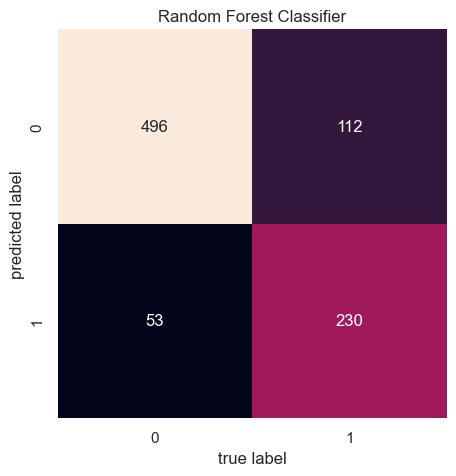

In [131]:
mat = confusion_matrix(df_labels, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Random Forest Classifier');

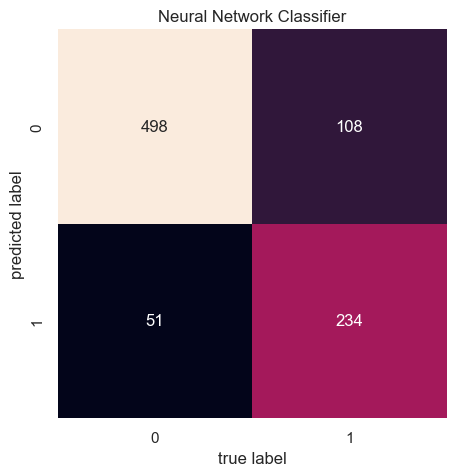

In [132]:
mat = confusion_matrix(df_labels, predictions_nn)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Neural Network Classifier');

While 1s are fewer than 0s, the model seems to predict each class at about the same level.

**Precision and Recall**

In [133]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(df_labels, predictions))
print(recall_score(df_labels, predictions))
print(f1_score(df_labels, predictions))

0.8127208480565371
0.672514619883041
0.736


**Test Set Evaluation**

In [134]:
df_test = test.copy()
df_test.loc[df_test['Age'] == 'NaN', 'Age'] = np.nan
df_test.loc[df_test['Fare'] == 0, 'Fare'] = np.nan
df_test.loc[df_test['Fare'] == 'NaN', 'Fare'] = np.nan
df_test['Fare_log'] = df_test['Fare'].apply(log_transform)

In [135]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,2.057860
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.945910
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,2.270836
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2.159003
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2.508582


In [136]:
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log']
cat_cols = ['Sex', 'Embarked']

In [137]:
test_num = df_test[num_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

df_num_test = num_pipeline.fit_transform(test_num)
df_num_test[:10]

array([[ 0.87348191,  0.38623105, -0.49947002, -0.4002477 , -0.49896797,
        -0.91499003],
       [ 0.87348191,  1.37137004,  0.61699237, -0.4002477 , -0.51384204,
        -1.02872532],
       [-0.31581919,  2.55353683, -0.49947002, -0.4002477 , -0.46563408,
        -0.69861795],
       [ 0.87348191, -0.20485235, -0.49947002, -0.4002477 , -0.48402037,
        -0.81223422],
       [ 0.87348191, -0.59890794,  0.61699237,  0.61989583, -0.41899568,
        -0.45708086],
       [ 0.87348191, -1.2293969 , -0.49947002, -0.4002477 , -0.47393033,
        -0.74831719],
       [ 0.87348191,  0.03158101, -0.49947002, -0.4002477 , -0.50255554,
        -0.94128   ],
       [-0.31581919, -0.28366347,  0.61699237,  0.61989583, -0.11920944,
         0.41532515],
       [ 0.87348191, -0.91415242, -0.49947002, -0.4002477 , -0.50973068,
        -0.99599335],
       [ 0.87348191, -0.67771906,  1.73345476, -0.4002477 , -0.20620799,
         0.22939548]])

In [138]:
from sklearn.compose import ColumnTransformer
num_attribs = list(df_test[num_cols])
cat_attribs = list(df_test[cat_cols])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

test_prepared = full_pipeline.fit_transform(df_test)

test_prepared[: 10]

array([[ 0.87348191,  0.38623105, -0.49947002, -0.4002477 , -0.49896797,
        -0.91499003,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.87348191,  1.37137004,  0.61699237, -0.4002477 , -0.51384204,
        -1.02872532,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.31581919,  2.55353683, -0.49947002, -0.4002477 , -0.46563408,
        -0.69861795,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.87348191, -0.20485235, -0.49947002, -0.4002477 , -0.48402037,
        -0.81223422,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.87348191, -0.59890794,  0.61699237,  0.61989583, -0.41899568,
        -0.45708086,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.87348191, -1.2293969 , -0.49947002, -0.4002477 , -0.47393033,
        -0.74831719,  0.        ,  1.        ,  0.        ,  0.        ,
         1.   

In [139]:
predictions = rf_clf.predict(test_prepared)
predictions_nn = mlp_clf.predict(test_prepared)

In [140]:
submission = pd.DataFrame({'PassengerId':test.PassengerId,
                           'Survived_RF':predictions,
                           'Survived_NN':predictions_nn})
submission.head()

,PassengerId,Survived_RF,Survived_NN
0,892,0,0
1,893,0,0
2,894,0,0
3,895,0,0
4,896,1,0
